In [7]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import block_diag

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('../../data'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics import Dynamics
from utils import get_form_initial_conditions
from centralized_newton import CentralizedNewton

In [8]:
# Position estimation error
def position_estimation_error(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

In [9]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3 + 2 + 1 
H = 30 # Window size [min]
invalid_rmse = 1e20 # [m]
grad_norm_order_mag = True
grad_norm_tol = 1e-6
max_iterations = 20
dyn = Dynamics()

In [10]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [11]:
def plots(k, algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, 1 / H * np.array(algorithm_class.cost_values), '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_title('Normalized Cost Function') 
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, 1 / H * np.array(algorithm_class.gradient_norm_values), '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_title('Normalized Gradient Norm')
    axs[1].grid()
    
    fig.suptitle(f'Solving MHE problem J(k) with k = {k}', fontsize=14)

    plt.tight_layout()
    plt.show()

In [12]:
# Seed for reproducibility
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
with open(f"../../data/tudatpy_form{formation}_ts_{int(dt)}.pkl", "rb") as file:
    X_true = pickle.load(file)[:, :, :K]

# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = dyn.f(dt, X_est[:, :, k])
position_estimation_error_1_initial, position_estimation_error_2_initial, position_estimation_error_3_initial, position_estimation_error_4_initial = position_estimation_error(X_est, X_true)

# Algorithm class to use
centralized_newton = CentralizedNewton(H, K, o, R, grad_norm_order_mag, grad_norm_tol, max_iterations)

# Observations
Y = np.zeros((o, 1, K))
for k in range(K):
    Y[:, :, k] = centralized_newton.h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))

Windows:   0%|          | 0/366 [00:00<?, ?it/s]

[Centralized Newton] Before applying the algorithm
Cost function: 301224484.3111788
Gradient norm: 2089042806.8821816
Global estimation error: 429.50490519551005
Initial conditions estimation errors: 272.4697073631671 m, 173.20827048054102 m, 227.7797328342984 m, 168.37460816595575 m
Position estimation errors: 779.5967223625395 m, 1207.5951811259074 m, 483.10528556068704 m, 358.43297364756006 m

[Centralized Newton] Iteration 1
Cost function: 404778.7462427466 (-99.87%)
Gradient norm: 1592966.2773675178 (-99.92%)
Global estimation error: 390.22777959977157 (-9.14%)
Initial conditions estimation errors: 30.486982200245873 m, 178.50373344663407 m, 259.5640052381113 m, 228.2785930708231 m
Position estimation errors: 23.543899992436515 m, 105.24302617652178 m, 183.59821216894036 m, 176.40864282309047 m

[Centralized Newton] Iteration 2
Cost function: 12885983.493269315 (3083.46%)
Gradient norm: 69616708.67405231 (4270.26%)
Global estimation error: 940.9617739772227 (141.13%)
Initial condi

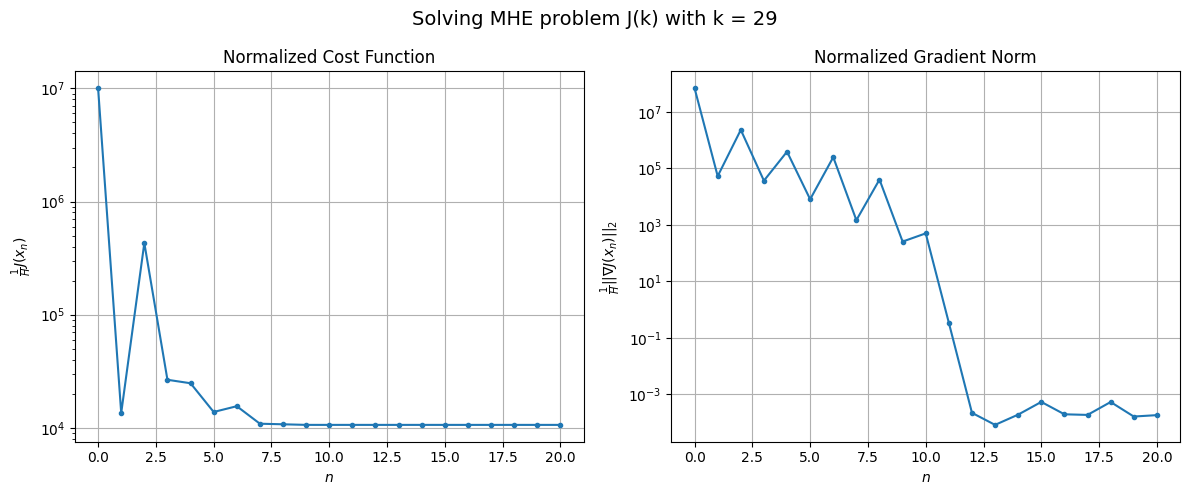

Windows:   0%|          | 1/366 [01:23<8:29:43, 83.79s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 309964.1664484822
Gradient norm: 2619507.5438552606
Global estimation error: 46.84597738423458
Initial conditions estimation errors: 23.648418714499087 m, 23.039027345596935 m, 23.702570385199103 m, 23.294120767454093 m
Position estimation errors: 27.389453155356172 m, 30.26326923145902 m, 26.47570266451284 m, 26.720068177905343 m

[Centralized Newton] Iteration 1
Cost function: 295681.9509402502 (-4.61%)
Gradient norm: 41.62041522010489 (-100.00%)
Global estimation error: 56.77618115020489 (21.20%)
Initial conditions estimation errors: 29.010178678170252 m, 28.548355506456947 m, 27.803112067788003 m, 28.17519977895488 m
Position estimation errors: 23.437312597899894 m, 26.4240887660271 m, 22.56737096547706 m, 22.864479377427575 m

[Centralized Newton] Iteration 2
Cost function: 295681.9502125443 (-0.00%)
Gradient norm: 0.01731951909907116 (-99.96%)
Global estimation error: 56.752870879757815 (-0.04%)
Initial conditions 

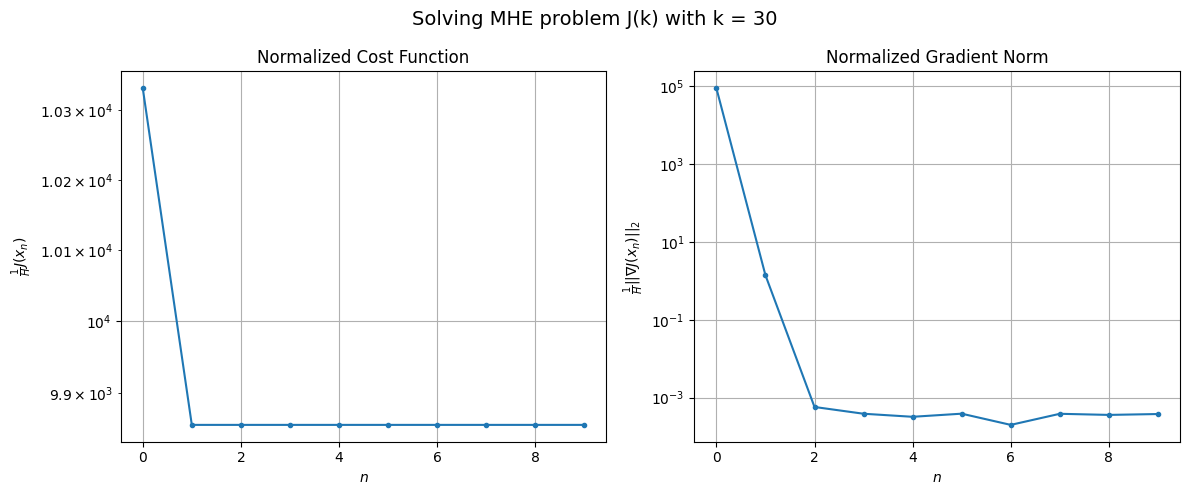

Windows:   1%|          | 2/366 [02:03<5:50:36, 57.79s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 290767.8829252949
Gradient norm: 2592936.7164866845
Global estimation error: 43.57960403741429
Initial conditions estimation errors: 22.780431000600096 m, 22.22842230090779 m, 21.325305142539904 m, 20.767779764116433 m
Position estimation errors: 27.202711898313687 m, 30.1430672795461 m, 26.494575881190602 m, 26.99639095728627 m

[Centralized Newton] Iteration 1
Cost function: 277310.3149082638 (-4.63%)
Gradient norm: 61.16196155795298 (-100.00%)
Global estimation error: 57.71412793881047 (32.43%)
Initial conditions estimation errors: 27.821467833552727 m, 27.946280000090763 m, 29.468421636753188 m, 30.123678382461883 m
Position estimation errors: 23.144603346437744 m, 25.33977709684444 m, 21.354325147157578 m, 21.534159284273553 m

[Centralized Newton] Iteration 2
Cost function: 277310.31345893786 (-0.00%)
Gradient norm: 0.053427567286750355 (-99.91%)
Global estimation error: 57.603208424706025 (-0.19%)
Initial conditio

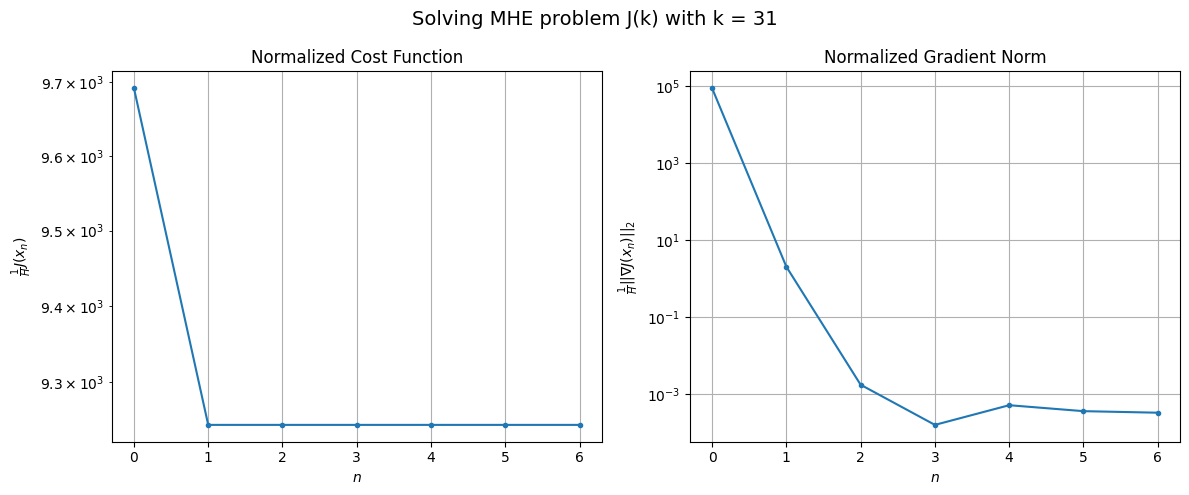

Windows:   1%|          | 3/366 [02:38<4:46:14, 47.31s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 273824.9925199528
Gradient norm: 2624164.1264147894
Global estimation error: 45.59982397772539
Initial conditions estimation errors: 22.086075181851474 m, 22.16045160912049 m, 23.24320086613847 m, 23.667824636993245 m
Position estimation errors: 26.695855072486445 m, 28.833672225289856 m, 24.935728162802647 m, 25.240079197252385 m

[Centralized Newton] Iteration 1
Cost function: 261052.6367177082 (-4.66%)
Gradient norm: 101.58072387455665 (-100.00%)
Global estimation error: 59.727303643091886 (30.98%)
Initial conditions estimation errors: 26.87745610975738 m, 25.625699767944106 m, 33.66755163490344 m, 32.47639869696692 m
Position estimation errors: 22.548512728866307 m, 26.011699152702043 m, 18.091556546394273 m, 17.03102220194996 m

[Centralized Newton] Iteration 2
Cost function: 261052.62561139982 (-0.00%)
Gradient norm: 0.6933760415787908 (-99.32%)
Global estimation error: 59.22275491940801 (-0.84%)
Initial conditions

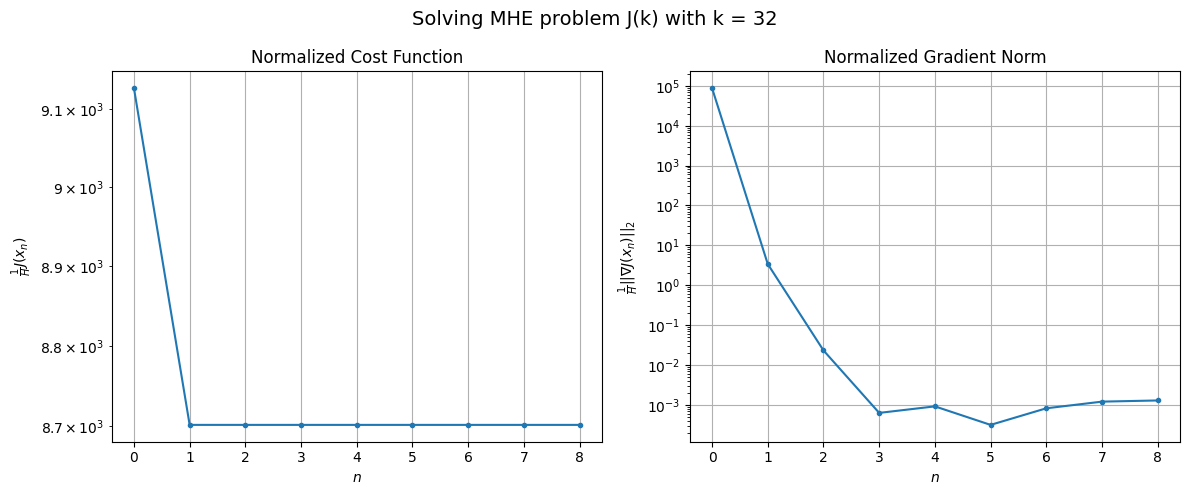

Windows:   1%|          | 4/366 [03:16<4:24:40, 43.87s/it]

[Centralized Newton] Before applying the algorithm
Cost function: 258016.2138278378
Gradient norm: 2726644.210044017
Global estimation error: 48.33950472915153
Initial conditions estimation errors: 21.567977411813214 m, 20.30020986279516 m, 27.17058409832037 m, 26.854203363811127 m
Position estimation errors: 25.810101227376542 m, 29.371987378165432 m, 21.464911014247843 m, 20.467906888586533 m

[Centralized Newton] Iteration 1
Cost function: 246112.4640875851 (-4.61%)
Gradient norm: 22.259431919034995 (-100.00%)
Global estimation error: 59.04185950370126 (22.14%)
Initial conditions estimation errors: 26.11667533407611 m, 25.65674107815967 m, 32.35128978816418 m, 33.15026103999188 m
Position estimation errors: 21.662428100652768 m, 24.361129801699796 m, 17.56444507049266 m, 17.223017026702692 m

[Centralized Newton] Iteration 2
Cost function: 246112.464041685 (-0.00%)
Gradient norm: 0.01968849222232248 (-99.91%)
Global estimation error: 59.0034256503421 (-0.07%)
Initial conditions esti

KeyboardInterrupt: 

In [13]:
first_round_stop_iteration = []
K_minus_H_next_rounds_stop_iteration = []

# Cold-start
x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))

# Apply the algorithm
X_est = np.zeros((n, 1, K))
for k in tqdm(range(H - 1, K), desc="Windows", leave=False):
    centralized_newton.cost_values, centralized_newton.gradient_norm_values = [], []
    x_init, x_est = centralized_newton.solve_MHE_problem(k, dt, Y, x_init, X_true[:, :, k - H + 1],  X_true[:, :, k])
    X_est[:, :, k] = x_est
    
    plots(k, centralized_newton)

    # Warm-start
    x_init = dyn.f(dt, x_init)

# After each Monte Carlo Run compute the RMSE_m for each K - H + 1 timestamps
position_estimation_error_1, position_estimation_error_2, position_estimation_error_3, position_estimation_error_4 = [], [], [], []
for k in range(H - 1, K):
    position_estimation_error_1.append(np.linalg.norm(X_est[:n_p, :, k] - X_true[:n_p, :, k]))
    position_estimation_error_2.append(np.linalg.norm(X_est[n_x:n_x + n_p, :, k] - X_true[n_x:n_x + n_p, :, k]))
    position_estimation_error_3.append(np.linalg.norm(X_est[2*n_x:2*n_x + n_p, :, k] - X_true[2*n_x:2*n_x + n_p, :, k]))
    position_estimation_error_4.append(np.linalg.norm(X_est[3*n_x:3*n_x + n_p, :, k] - X_true[3*n_x:3*n_x + n_p, :, k]))
rmse_1 = np.sqrt(np.mean(np.array(position_estimation_error_1) ** 2))
rmse_2 = np.sqrt(np.mean(np.array(position_estimation_error_2) ** 2))
rmse_3 = np.sqrt(np.mean(np.array(position_estimation_error_3) ** 2))
rmse_4 = np.sqrt(np.mean(np.array(position_estimation_error_4) ** 2))
print(f'This Monte Carlo run RMSE for {K - H + 1} timestamps:')
print(f'RMSE_1 = {np.mean(rmse_1)}\nRMSE_2 = {np.mean(rmse_2)}\nRMSE_3 = {np.mean(rmse_3)}\nRMSE_4 = {np.mean(rmse_4)}')
print(f'CentralizedNewton applied to J(H - 1) converged with {first_round_stop_iteration} iterations.')
print(f'CentralizedNewton applied to J(k) with k = H, ..., K - 1 converged with {np.mean(K_minus_H_next_rounds_stop_iteration)} iterations on average.')

In [ ]:
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, K) / dt
algorithm = "Centralized Newton"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, position_estimation_error_1_initial, ".-", label="Initial")
axs[0, 0].plot(time[H - 1:], position_estimation_error_1, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, position_estimation_error_2_initial, ".-", label="Initial")
axs[0, 1].plot(time[H - 1:], position_estimation_error_2, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, position_estimation_error_3_initial, ".-", label="Initial")
axs[1, 0].plot(time[H - 1:], position_estimation_error_3, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, position_estimation_error_4_initial, ".-", label="Initial")
axs[1, 1].plot(time[H - 1:], position_estimation_error_4, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()